In [1]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.1 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def get_dicom_files_from_folder(folder_path):
    dicom_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.dcm')]
    return sorted(dicom_files)  # Sorting ensures correct slice order

def load_dicom_stack(dicom_files):
    slices = [pydicom.dcmread(file) for file in dicom_files]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]) if hasattr(x, "ImagePositionPatient") else x.InstanceNumber)
    pixel_stack = np.stack([s.pixel_array.astype(np.float32) for s in slices])
    return pixel_stack

In [5]:
def generate_bssfp_stack(t1_stack, t2_stack, flip_angle=25, TR=12):
    slices, height, width = t1_stack.shape
    bssfp_stack = np.zeros((slices, height, width), dtype=np.float32)

    for z in range(slices):
        print(f"Processing slice {z+1}/{slices}")

        # Extract the T1 and T2 maps for the current slice
        t1_image = t1_stack[z, :, :]
        t2_image = t2_stack[z, :, :]

        # Generate synthetic T1 and T2 relaxation maps
        T1_map = 400 + (1600 * t1_image)  # T1 in [400ms, 2000ms]
        T2_map = 40 + (40 * t2_image)     # T2 in [40ms, 80ms]
        M0_map = t1_image                 # Assume T1-weighted intensity as M0 proxy

        # Calculate E1 and E2
        E1_map = np.exp(-TR / T1_map)
        E2_map = np.exp(-TR / T2_map)
        alpha = np.radians(flip_angle)

        # Compute the bSSFP signal
        S_map1 = M0_map * np.sqrt(E2_map * (1 - E1_map)) * np.sin(alpha) / (
            1 - (E1_map - E2_map) * np.cos(alpha) - E1_map * E2_map
        )

        S_map1_complex = S_map1.astype(np.complex128)

        # Add off-resonance effects
        image_size = T1_map.shape
        df_map = np.random.uniform(-100, 100, image_size)  # Off-resonance frequency map (Hz)
        phi_map = 2 * np.pi * df_map * TR / 1000  # Convert TR to seconds
        S_map1_complex *= np.exp(1j * phi_map)

        bssfp_stack[z, :, :] = np.abs(S_map1_complex)

    return bssfp_stack

In [6]:
def stack_of_stars_reconstruction(stack, num_spokes=400, density=1.5, noise_std=0.01):
    """
    Reconstruct a 3D stack of images using the Stack-of-Stars sampling pattern.

    Parameters:
        stack (ndarray): Input 3D stack (slices x height x width).
        num_spokes (int): Number of radial spokes. Default is 400.
        density (float): Radial density. Default is 1.5.
        noise_std (float): Standard deviation of Gaussian noise. Default is 0.01.

    Returns:
        reconstructed_stack (ndarray): Reconstructed 3D stack of images.
    """
    slices, height, width = stack.shape
    reconstructed_stack = np.zeros((slices, height, width), dtype=np.float32)

    # Iterate through each slice
    for z in range(slices):
        print(f"Reconstructing slice {z+1}/{slices}")
        image = stack[z, :, :]

        # Perform 2D Fourier transform to get k-space
        cartesian_kspace = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

        # Define Cartesian grid
        kx_cart, ky_cart = np.meshgrid(
            np.linspace(-1, 1, width),
            np.linspace(-1, 1, height)
        )
        kx_cart = kx_cart.flatten()
        ky_cart = ky_cart.flatten()

        # Create radial sampling pattern
        kx, ky = [], []
        golden_angle = np.pi * (3 - np.sqrt(5))  # Golden angle for uniform radial coverage
        radii = np.linspace(0, 1, height // 2) ** density

        for i in range(num_spokes):
            angle = i * golden_angle
            for r in radii:
                kx.append(r * np.cos(angle))
                ky.append(r * np.sin(angle))

        kx = np.array(kx)
        ky = np.array(ky)

        # Interpolate Cartesian k-space data to radial points
        radial_kspace = griddata(
            (kx_cart, ky_cart),
            cartesian_kspace.flatten(),
            (kx, ky),
            method='linear',
            fill_value=0
        )

        # Add Gaussian noise
        radial_kspace_noisy = radial_kspace + noise_std * (
            np.random.normal(size=radial_kspace.shape) +
            1j * np.random.normal(size=radial_kspace.shape)
        )

        # Re-grid radial data back to Cartesian grid
        cartesian_kspace_rg = griddata(
            (kx, ky),
            radial_kspace_noisy,
            (kx_cart, ky_cart),
            method='linear',
            fill_value=0
        ).reshape((height, width))

        # Reconstruct the image from re-gridded k-space
        reconstructed_image = np.abs(np.fft.ifftshift(np.fft.ifft2(cartesian_kspace_rg)))
        reconstructed_stack[z, :, :] = reconstructed_image

    return reconstructed_stack

In [ ]:
t1_folder = "/content/drive/MyDrive/T1_Weighted/FLASH_3D_stitched"
t2_folder = "/content/drive/MyDrive/T2_Weighted/TSE_3D_stitched"

t1_dicom_files = get_dicom_files_from_folder(t1_folder)
t2_dicom_files = get_dicom_files_from_folder(t2_folder)

t1_stack = load_dicom_stack(t1_dicom_files)
t2_stack = load_dicom_stack(t2_dicom_files)

bssfp_stack = generate_bssfp_stack(t1_stack, t2_stack, flip_angle=25, TR=12)
reconstructed_stack = stack_of_stars_reconstruction(bssfp_stack, num_spokes=402, density=1.5)

slice_index = t1_stack.shape[0] // 2

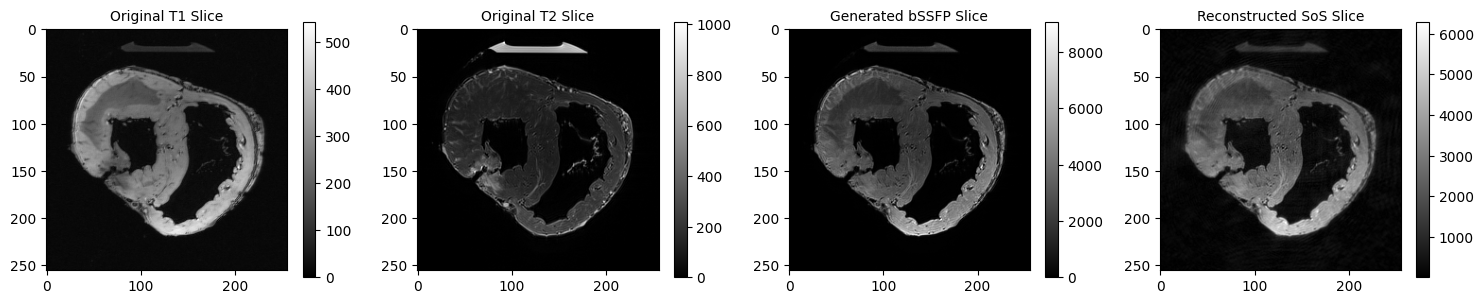

In [13]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 4, 1)
plt.title("Original T1 Slice", fontsize = 10)
plt.imshow(t1_stack[slice_index, :, :], cmap='gray')
plt.colorbar()

plt.subplot(1, 4, 2)
plt.title("Original T2 Slice", fontsize = 10)
plt.imshow(t2_stack[slice_index, :, :], cmap='gray')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.title("Generated bSSFP Slice", fontsize = 10)
plt.imshow(bssfp_stack[slice_index, :, :], cmap='gray')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.title("Reconstructed SoS Slice", fontsize = 10)
plt.imshow(reconstructed_stack[slice_index, :, :], cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()